# Clustering Descriptive Statistics

Compare flat clustering runs (distance\_threshold=0.96 vs 0.98) and
the recursive sub-clustering run across all initiatives.

In [13]:
import json
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CLUSTERING_DIR = "clustering_output"
MODEL = "paraphrase-multilingual-MiniLM-L12-v2"

# Flat runs (old-style: integer labels)
FLAT_THRESHOLDS = [0.96, 0.98]

# Recursive sub-clustering run pattern (has max_cluster_size in params)
# Will be auto-detected from files

def load_flat_run(dt, linkage="average"):
    """Load all flat clustering results for a given distance threshold."""
    suffix = f"_agglomerative_{MODEL}_distance_threshold={dt}_linkage={linkage}.json"
    records = []
    for fname in sorted(os.listdir(CLUSTERING_DIR)):
        if not fname.endswith(suffix):
            continue
        init_id = fname.replace(suffix, "")
        with open(os.path.join(CLUSTERING_DIR, fname)) as f:
            d = json.load(f)
        assigns = d["cluster_assignments"]
        sizes = Counter(assigns.values())
        size_values = list(sizes.values())
        records.append({
            "initiative_id": init_id,
            "short_title": d.get("short_title", ""),
            "n_feedback": len(assigns),
            "n_clusters": d["cluster_n_clusters"],
            "silhouette": d["cluster_silhouette"],
            "noise_count": d["cluster_noise_count"],
            "singleton_clusters": sum(1 for s in size_values if s == 1),
            "largest_cluster": max(size_values),
            "smallest_cluster": min(size_values),
            "median_cluster_size": float(np.median(size_values)),
            "mean_cluster_size": float(np.mean(size_values)),
            "cluster_sizes": size_values,
        })
    return pd.DataFrame(records)


def load_recursive_run(pattern_glob="*max_cluster_size*max_depth*"):
    """Load all recursive sub-clustering results. Auto-detects by param keys."""
    import glob as globmod
    files = sorted(globmod.glob(os.path.join(CLUSTERING_DIR, pattern_glob)))
    if not files:
        return None, None
    records = []
    params_label = None
    for fpath in files:
        fname = os.path.basename(fpath)
        with open(fpath) as f:
            d = json.load(f)
        if params_label is None:
            p = d.get("cluster_params", {})
            params_label = (f"dt={p.get('distance_threshold')}, "
                           f"max={p.get('max_cluster_size')}, "
                           f"step={p.get('sub_cluster_step')}, "
                           f"depth={p.get('max_depth')}")
        assigns = d["cluster_assignments"]
        labels = list(assigns.values())
        sizes = Counter(labels)
        size_values = list(sizes.values())

        # Hierarchy stats
        depths = [str(l).count(".") for l in labels]  # 0=top, 1=sub, 2=sub-sub...
        label_depths = {l: str(l).count(".") for l in set(labels)}
        top_labels = [str(l).split(".")[0] for l in labels]
        top_sizes = Counter(top_labels)

        records.append({
            "initiative_id": fname.split("_agglomerative_")[0],
            "short_title": d.get("short_title", ""),
            "n_feedback": len(assigns),
            "n_clusters": d["cluster_n_clusters"],
            "silhouette": d["cluster_silhouette"],
            "singleton_clusters": sum(1 for s in size_values if s == 1),
            "largest_cluster": max(size_values),
            "smallest_cluster": min(size_values),
            "median_cluster_size": float(np.median(size_values)),
            "mean_cluster_size": float(np.mean(size_values)),
            "cluster_sizes": size_values,
            # Hierarchy-specific
            "n_top_clusters": len(top_sizes),
            "n_sub_clustered": sum(1 for l in set(labels) if "." in str(l)),
            "max_depth": max(depths),
            "mean_depth": float(np.mean(depths)),
            "top_largest": max(top_sizes.values()),
            "clusters_at_depth_0": sum(1 for l in set(labels) if "." not in str(l)),
            "clusters_at_depth_1": sum(1 for l in set(labels) if str(l).count(".") == 1),
            "clusters_at_depth_2": sum(1 for l in set(labels) if str(l).count(".") == 2),
            "clusters_at_depth_3": sum(1 for l in set(labels) if str(l).count(".") >= 3),
        })
    return pd.DataFrame(records), params_label


# Load all runs
runs = {}
for dt in FLAT_THRESHOLDS:
    runs[f"flat dt={dt}"] = load_flat_run(dt)
    print(f"flat dt={dt}: {len(runs[f'flat dt={dt}'])} initiatives loaded")

recursive_df, recursive_label = load_recursive_run()
if recursive_df is not None:
    runs[f"recursive ({recursive_label})"] = recursive_df
    print(f"recursive ({recursive_label}): {len(recursive_df)} initiatives loaded")
else:
    print("No recursive sub-clustering results found yet.")

flat dt=0.96: 111 initiatives loaded
flat dt=0.98: 111 initiatives loaded
recursive (dt=0.75, max=20, step=None, depth=3): 555 initiatives loaded


In [14]:
# ── Per-run summary statistics ──────────────────────────────────────────
summary_rows = []
for label, df in runs.items():
    row = {
        "run": label,
        "initiatives": len(df),
        "total_feedback": df["n_feedback"].sum(),
        "total_clusters": df["n_clusters"].sum(),
        "mean_clusters_per_init": df["n_clusters"].mean(),
        "median_clusters_per_init": df["n_clusters"].median(),
        "mean_silhouette": df["silhouette"].mean(),
        "median_silhouette": df["silhouette"].median(),
        "mean_feedback_per_init": df["n_feedback"].mean(),
        "total_singletons": df["singleton_clusters"].sum(),
        "singleton_pct_of_clusters": df["singleton_clusters"].sum() / df["n_clusters"].sum() * 100,
        "mean_largest_cluster": df["largest_cluster"].mean(),
        "mean_median_cluster_size": df["median_cluster_size"].mean(),
    }
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).set_index("run")
summary.T

run,flat dt=0.96,flat dt=0.98,"recursive (dt=0.75, max=20, step=None, depth=3)"
initiatives,111.000000,111.000000,555.000000
total_feedback,78035.000000,78035.000000,390175.000000
total_clusters,6483.000000,5526.000000,126598.000000
mean_clusters_per_init,58.405405,49.783784,228.104505
median_clusters_per_init,33.000000,28.000000,89.000000
mean_silhouette,0.080196,0.083198,-0.151702
median_silhouette,0.071990,0.071876,-0.158908
mean_feedback_per_init,703.018018,703.018018,703.018018
total_singletons,3460.000000,2815.000000,79058.000000
singleton_pct_of_clusters,53.370353,50.941006,62.448064


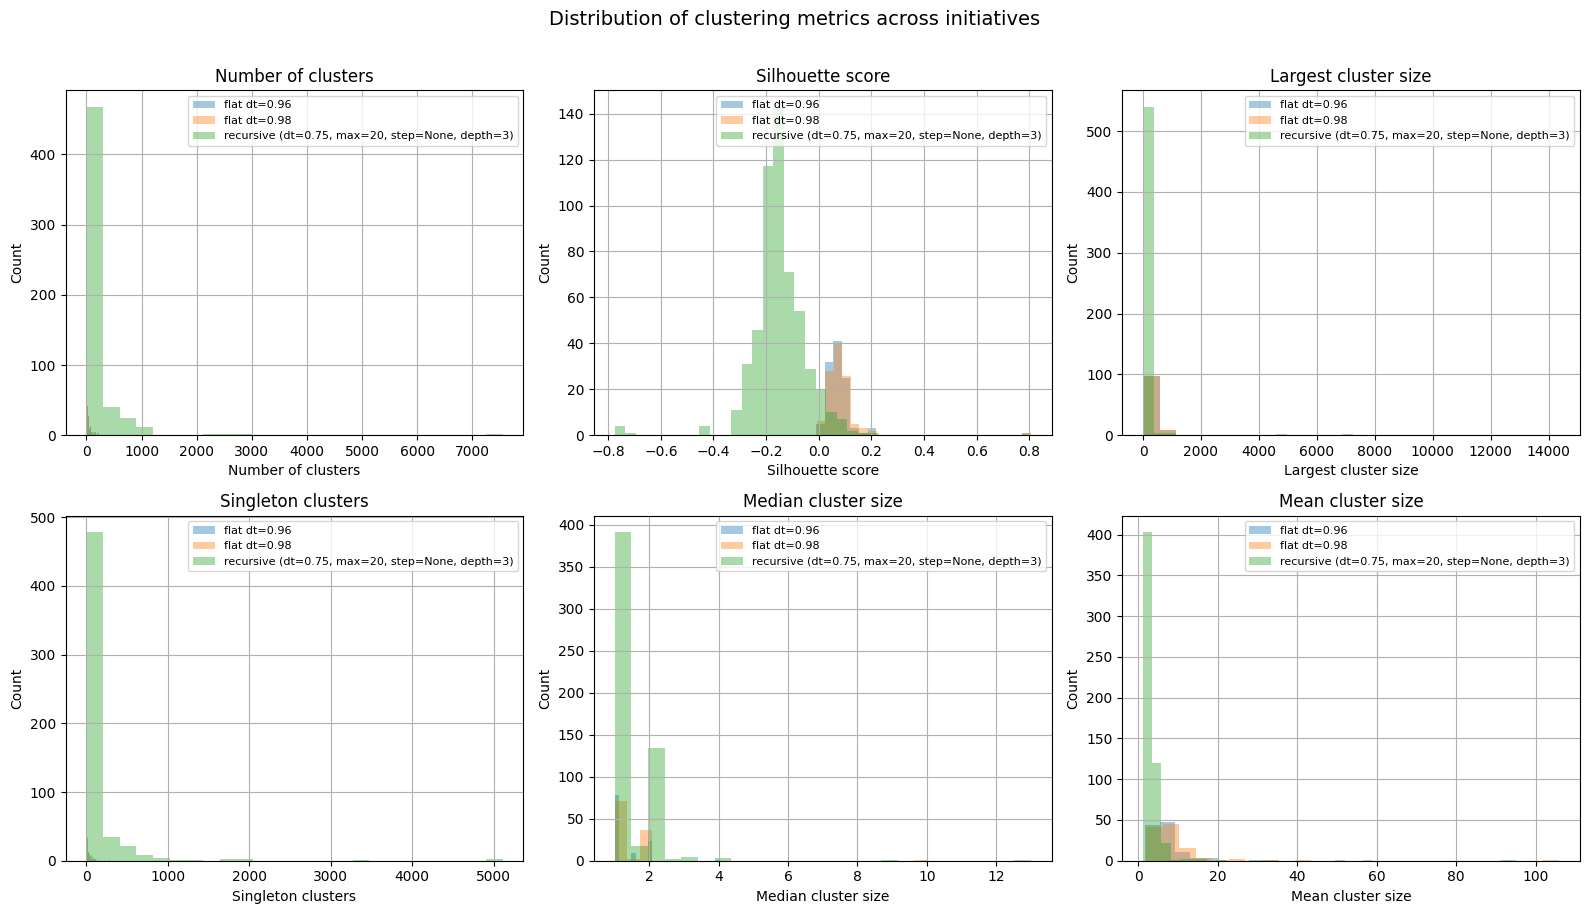

In [15]:
# ── Side-by-side distributions: n_clusters, silhouette, largest cluster ─
metrics = [
    ("n_clusters", "Number of clusters"),
    ("silhouette", "Silhouette score"),
    ("largest_cluster", "Largest cluster size"),
    ("singleton_clusters", "Singleton clusters"),
    ("median_cluster_size", "Median cluster size"),
    ("mean_cluster_size", "Mean cluster size"),
]
n_runs = len(runs)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for ax, (col, label) in zip(axes.flat, metrics):
    for run_label, df in runs.items():
        df[col].hist(ax=ax, bins=25, alpha=0.4, label=run_label)
    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.set_title(label)
    ax.legend(fontsize=8)

plt.suptitle("Distribution of clustering metrics across initiatives", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

In [16]:
# ── Per-initiative comparison: flat 0.96 vs flat 0.98 ──────────────────
flat_96 = runs["flat dt=0.96"]
flat_98 = runs["flat dt=0.98"]
merged = flat_96.merge(flat_98, on="initiative_id", suffixes=("_96", "_98"))
print(f"Matched initiatives: {len(merged)}")

merged["cluster_diff"] = merged["n_clusters_96"] - merged["n_clusters_98"]
merged["silhouette_diff"] = merged["silhouette_96"] - merged["silhouette_98"]
merged["singleton_diff"] = merged["singleton_clusters_96"] - merged["singleton_clusters_98"]
merged["largest_diff"] = merged["largest_cluster_96"] - merged["largest_cluster_98"]

print(f"\ndt=0.96 produces more clusters in {(merged['cluster_diff'] > 0).sum()}/{len(merged)} initiatives")
print(f"dt=0.96 produces fewer clusters in {(merged['cluster_diff'] < 0).sum()}/{len(merged)} initiatives")
print(f"Same cluster count: {(merged['cluster_diff'] == 0).sum()}/{len(merged)}")
print(f"\nMean cluster count difference (0.96 - 0.98): {merged['cluster_diff'].mean():.2f}")
print(f"Mean silhouette difference (0.96 - 0.98): {merged['silhouette_diff'].mean():.4f}")
print(f"Mean singleton difference (0.96 - 0.98): {merged['singleton_diff'].mean():.2f}")

Matched initiatives: 111

dt=0.96 produces more clusters in 106/111 initiatives
dt=0.96 produces fewer clusters in 0/111 initiatives
Same cluster count: 5/111

Mean cluster count difference (0.96 - 0.98): 8.62
Mean silhouette difference (0.96 - 0.98): -0.0030
Mean singleton difference (0.96 - 0.98): 5.81


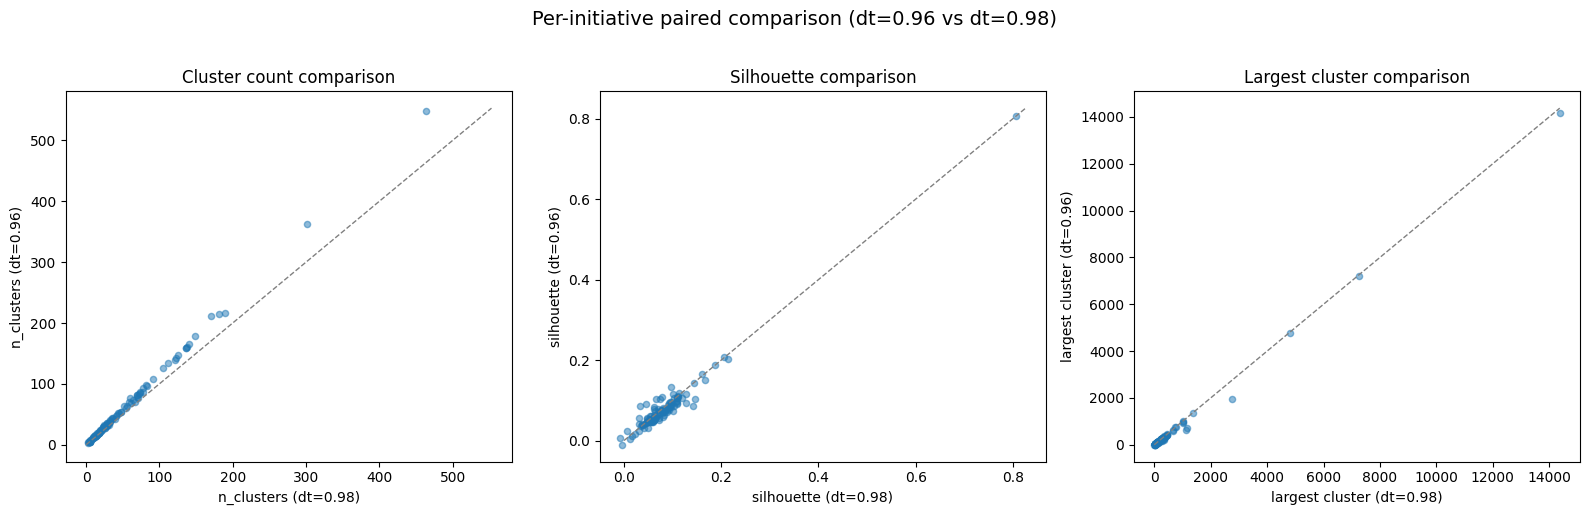

In [17]:
# ── Scatter: n_clusters 0.96 vs 0.98 ───────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax = axes[0]
ax.scatter(merged["n_clusters_98"], merged["n_clusters_96"], alpha=0.5, s=20)
lim = max(merged["n_clusters_98"].max(), merged["n_clusters_96"].max()) + 5
ax.plot([0, lim], [0, lim], "--", color="gray", linewidth=1)
ax.set_xlabel("n_clusters (dt=0.98)")
ax.set_ylabel("n_clusters (dt=0.96)")
ax.set_title("Cluster count comparison")

ax = axes[1]
ax.scatter(merged["silhouette_98"], merged["silhouette_96"], alpha=0.5, s=20)
lim = max(merged["silhouette_98"].max(), merged["silhouette_96"].max()) + 0.02
ax.plot([0, lim], [0, lim], "--", color="gray", linewidth=1)
ax.set_xlabel("silhouette (dt=0.98)")
ax.set_ylabel("silhouette (dt=0.96)")
ax.set_title("Silhouette comparison")

ax = axes[2]
ax.scatter(merged["largest_cluster_98"], merged["largest_cluster_96"], alpha=0.5, s=20)
lim = max(merged["largest_cluster_98"].max(), merged["largest_cluster_96"].max()) + 5
ax.plot([0, lim], [0, lim], "--", color="gray", linewidth=1)
ax.set_xlabel("largest cluster (dt=0.98)")
ax.set_ylabel("largest cluster (dt=0.96)")
ax.set_title("Largest cluster comparison")

plt.suptitle("Per-initiative paired comparison (dt=0.96 vs dt=0.98)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

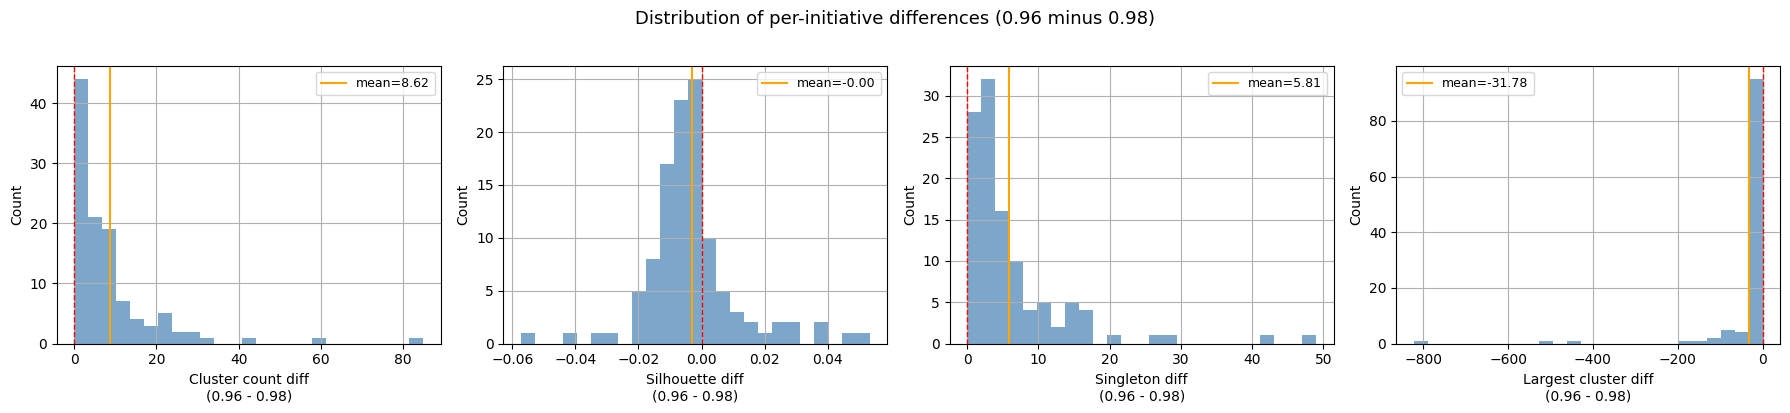

In [18]:
# ── Difference distributions ───────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (col, label) in zip(axes, [
    ("cluster_diff", "Cluster count diff\n(0.96 - 0.98)"),
    ("silhouette_diff", "Silhouette diff\n(0.96 - 0.98)"),
    ("singleton_diff", "Singleton diff\n(0.96 - 0.98)"),
    ("largest_diff", "Largest cluster diff\n(0.96 - 0.98)"),
]):
    merged[col].hist(ax=ax, bins=25, color="steelblue", alpha=0.7)
    ax.axvline(0, color="red", linewidth=1, linestyle="--")
    ax.axvline(merged[col].mean(), color="orange", linewidth=1.5, linestyle="-", label=f"mean={merged[col].mean():.2f}")
    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

plt.suptitle("Distribution of per-initiative differences (0.96 minus 0.98)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

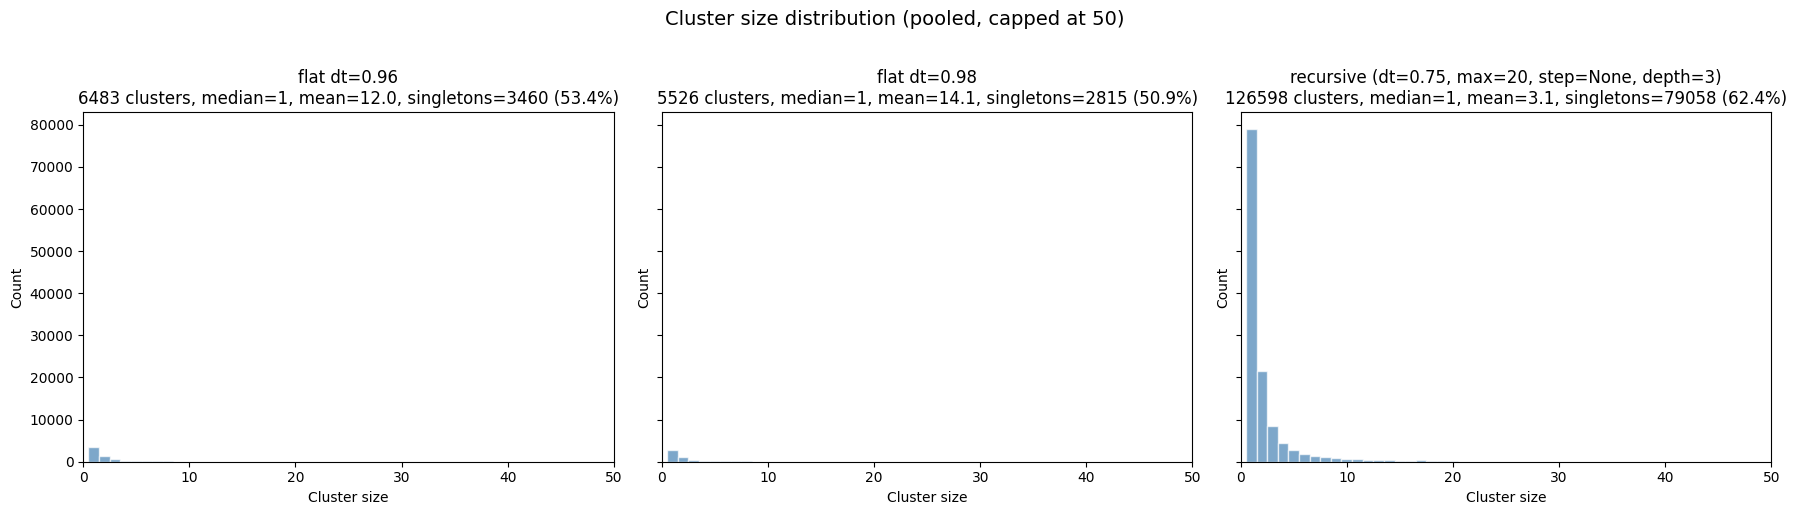

In [19]:
# ── Cluster size distributions (pooled across all initiatives) ─────────
n_runs = len(runs)
fig, axes = plt.subplots(1, n_runs, figsize=(6 * n_runs, 5), sharey=True)
if n_runs == 1:
    axes = [axes]

for ax, (run_label, df) in zip(axes, runs.items()):
    all_sizes = []
    for sizes in df["cluster_sizes"]:
        all_sizes.extend(sizes)
    all_sizes = np.array(all_sizes)
    
    ax.hist(all_sizes, bins=np.arange(0.5, min(all_sizes.max() + 1.5, 52), 1),
            color="steelblue", alpha=0.7, edgecolor="white")
    ax.set_xlabel("Cluster size")
    ax.set_ylabel("Count")
    ax.set_title(f"{run_label}\n{len(all_sizes)} clusters, "
                 f"median={np.median(all_sizes):.0f}, "
                 f"mean={np.mean(all_sizes):.1f}, "
                 f"singletons={np.sum(all_sizes == 1)} ({np.sum(all_sizes == 1)/len(all_sizes)*100:.1f}%)")
    ax.set_xlim(0, 50)

plt.suptitle("Cluster size distribution (pooled, capped at 50)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

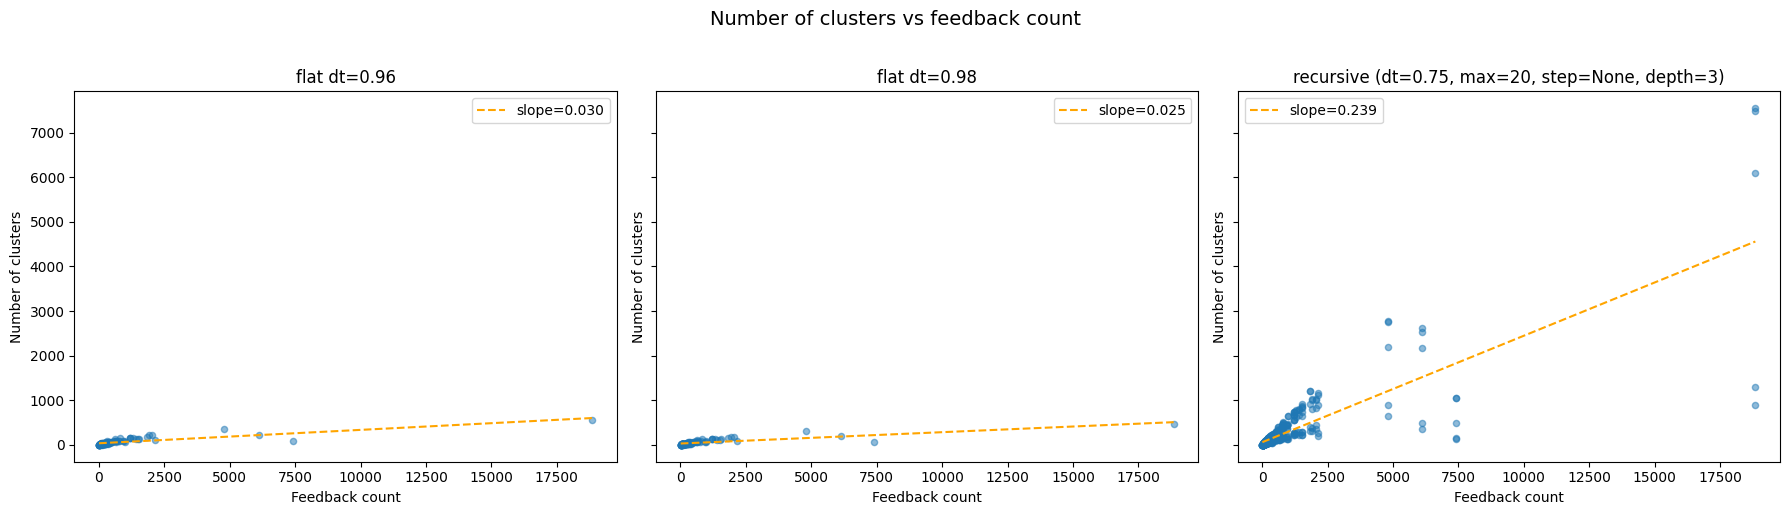

In [20]:
# ── Clusters vs feedback count (scatter by run) ────────────────────────
n_runs = len(runs)
fig, axes = plt.subplots(1, n_runs, figsize=(6 * n_runs, 5), sharey=True)
if n_runs == 1:
    axes = [axes]

for ax, (run_label, df) in zip(axes, runs.items()):
    ax.scatter(df["n_feedback"], df["n_clusters"], alpha=0.5, s=20)
    ax.set_xlabel("Feedback count")
    ax.set_ylabel("Number of clusters")
    ax.set_title(run_label)
    z = np.polyfit(df["n_feedback"], df["n_clusters"], 1)
    xs = np.linspace(df["n_feedback"].min(), df["n_feedback"].max(), 100)
    ax.plot(xs, np.polyval(z, xs), "--", color="orange", label=f"slope={z[0]:.3f}")
    ax.legend()

plt.suptitle("Number of clusters vs feedback count", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

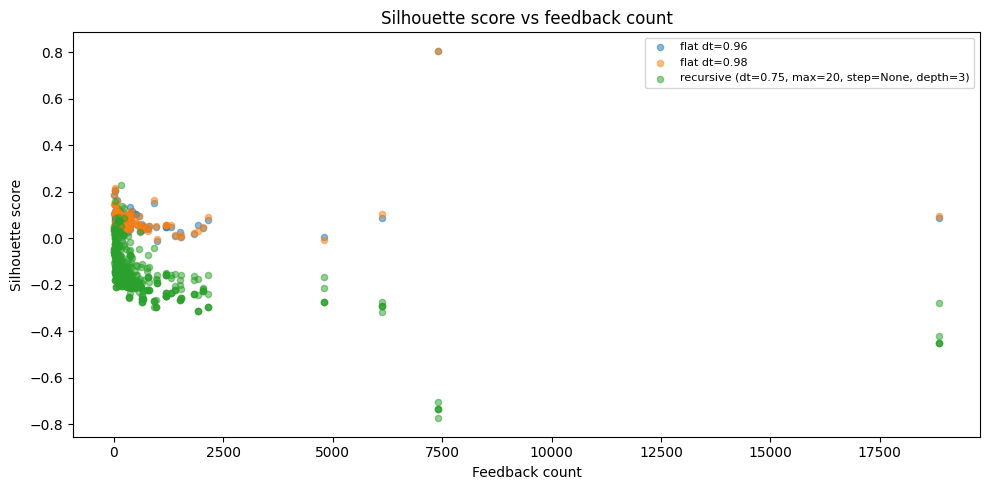

In [21]:
# ── Silhouette vs feedback count ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

for run_label, df in runs.items():
    ax.scatter(df["n_feedback"], df["silhouette"], alpha=0.5, s=20, label=run_label)

ax.set_xlabel("Feedback count")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette score vs feedback count")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [22]:
# ── Top / bottom initiatives by silhouette ─────────────────────────────
for run_label, df in runs.items():
    df_sorted = df.sort_values("silhouette", ascending=False)
    print(f"\n{'='*70}")
    print(f"{run_label}  —  Top 10 by silhouette")
    print(f"{'='*70}")
    print(df_sorted[["initiative_id", "short_title", "n_feedback", "n_clusters",
             "silhouette", "singleton_clusters", "largest_cluster"]].head(10).to_string(index=False))
    print(f"\nBottom 10 by silhouette")
    print(df_sorted[["initiative_id", "short_title", "n_feedback", "n_clusters",
             "silhouette", "singleton_clusters", "largest_cluster"]].tail(10).to_string(index=False))


flat dt=0.96  —  Top 10 by silhouette
initiative_id                                                                                                     short_title  n_feedback  n_clusters  silhouette  singleton_clusters  largest_cluster
        13142                                                                       Revision of the EU Pollinators Initiative        7413          78    0.805679                  47             7210
        13275 Act amending Implementing Regulation (EU) 2018/2066 on the monitoring and reporting of greenhouse gas emissions          27           4    0.206621                   3               24
        14031                                                       Fitness check of EU legislation on trade in seal products          18           8    0.201630                   3                7
        13981                                  Regulatory measure on the review of ecodesign requirements for industrial fans          17           5    0.187171    

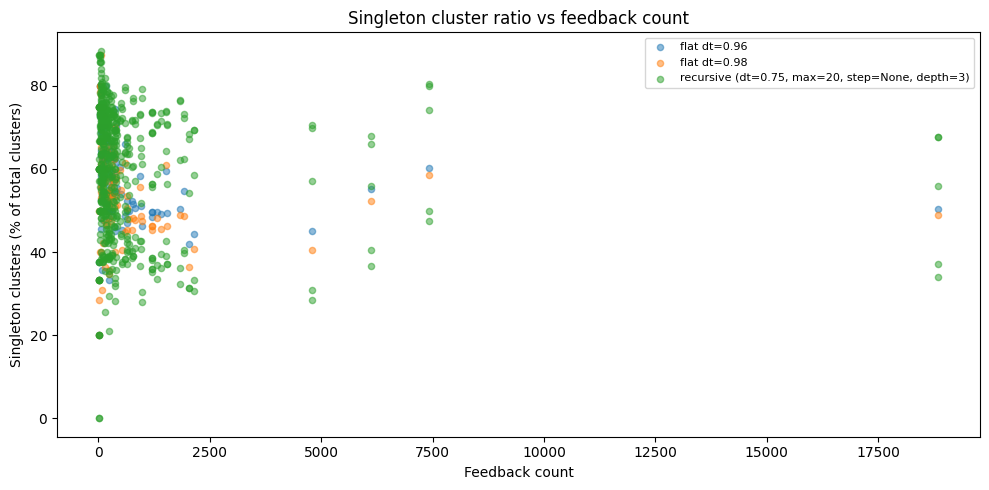

In [23]:
# ── Singleton ratio vs feedback count ──────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

for run_label, df in runs.items():
    df_tmp = df.copy()
    df_tmp["singleton_pct"] = df_tmp["singleton_clusters"] / df_tmp["n_clusters"] * 100
    ax.scatter(df_tmp["n_feedback"], df_tmp["singleton_pct"], alpha=0.5, s=20, label=run_label)

ax.set_xlabel("Feedback count")
ax.set_ylabel("Singleton clusters (% of total clusters)")
ax.set_title("Singleton cluster ratio vs feedback count")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

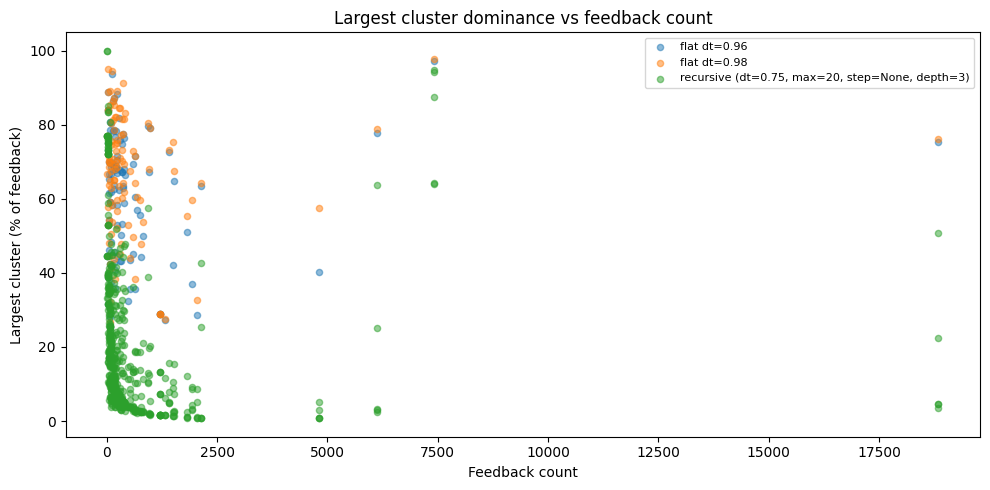

In [24]:
# ── Largest cluster as % of feedback ───────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

for run_label, df in runs.items():
    df_tmp = df.copy()
    df_tmp["largest_pct"] = df_tmp["largest_cluster"] / df_tmp["n_feedback"] * 100
    ax.scatter(df_tmp["n_feedback"], df_tmp["largest_pct"], alpha=0.5, s=20, label=run_label)

ax.set_xlabel("Feedback count")
ax.set_ylabel("Largest cluster (% of feedback)")
ax.set_title("Largest cluster dominance vs feedback count")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## Recursive sub-clustering analysis

The following cells analyze the hierarchical structure of the recursive run.

In [25]:
# ── Recursive run: hierarchy depth analysis ────────────────────────────
if recursive_df is not None:
    rdf = recursive_df

    print(f"Recursive run: {recursive_label}")
    print(f"Initiatives: {len(rdf)}")
    print(f"\n── Depth distribution across initiatives ──")
    print(f"Max depth reached (max across all):  {rdf['max_depth'].max()}")
    print(f"Mean max depth per initiative:        {rdf['max_depth'].mean():.2f}")
    print(f"Initiatives reaching depth 0 only:    {(rdf['max_depth'] == 0).sum()}")
    print(f"Initiatives reaching depth 1:         {(rdf['max_depth'] >= 1).sum()}")
    print(f"Initiatives reaching depth 2:         {(rdf['max_depth'] >= 2).sum()}")
    print(f"Initiatives reaching depth 3+:        {(rdf['max_depth'] >= 3).sum()}")

    print(f"\n── Cluster counts by depth ──")
    print(f"Total clusters at depth 0 (top-level, not split): {rdf['clusters_at_depth_0'].sum()}")
    print(f"Total clusters at depth 1 (sub-clusters):         {rdf['clusters_at_depth_1'].sum()}")
    print(f"Total clusters at depth 2 (sub-sub-clusters):     {rdf['clusters_at_depth_2'].sum()}")
    print(f"Total clusters at depth 3+ (deeper):              {rdf['clusters_at_depth_3'].sum()}")
    total_leaf = rdf["n_clusters"].sum()
    total_sub = rdf["n_sub_clustered"].sum()
    print(f"\nTotal leaf clusters:       {total_leaf}")
    print(f"Of which sub-clustered:    {total_sub} ({total_sub/total_leaf*100:.1f}%)")

    print(f"\n── Effect on largest cluster ──")
    print(f"Mean largest cluster (recursive):  {rdf['largest_cluster'].mean():.1f}")
    # Compare with flat 0.96
    flat_96 = runs.get("flat dt=0.96")
    if flat_96 is not None:
        print(f"Mean largest cluster (flat 0.96):  {flat_96['largest_cluster'].mean():.1f}")
        m = flat_96.merge(rdf, on="initiative_id", suffixes=("_flat", "_rec"))
        reduction = (m["largest_cluster_flat"] - m["largest_cluster_rec"])
        improved = (reduction > 0).sum()
        print(f"Initiatives where recursive reduced largest cluster: {improved}/{len(m)}")
        print(f"Mean reduction in largest cluster: {reduction.mean():.1f}")
else:
    print("No recursive run loaded — run cluster_all_initiatives.py first.")

Recursive run: dt=0.75, max=20, step=None, depth=3
Initiatives: 555

── Depth distribution across initiatives ──
Max depth reached (max across all):  4
Mean max depth per initiative:        2.32
Initiatives reaching depth 0 only:    67
Initiatives reaching depth 1:         488
Initiatives reaching depth 2:         369
Initiatives reaching depth 3+:        239

── Cluster counts by depth ──
Total clusters at depth 0 (top-level, not split): 39456
Total clusters at depth 1 (sub-clusters):         49489
Total clusters at depth 2 (sub-sub-clusters):     23776
Total clusters at depth 3+ (deeper):              13877

Total leaf clusters:       126598
Of which sub-clustered:    87142 (68.8%)

── Effect on largest cluster ──
Mean largest cluster (recursive):  130.2
Mean largest cluster (flat 0.96):  451.2
Initiatives where recursive reduced largest cluster: 502/555
Mean reduction in largest cluster: 321.0


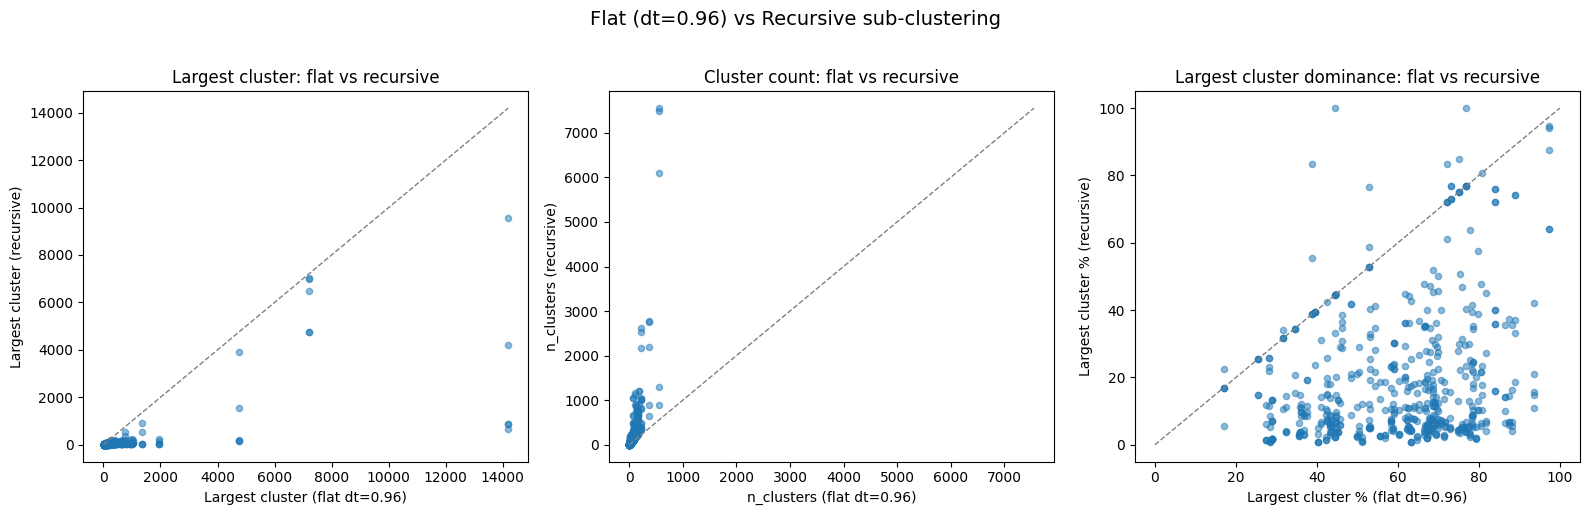

In [26]:
# ── Recursive vs flat: paired largest-cluster comparison ───────────────
if recursive_df is not None:
    flat_96 = runs.get("flat dt=0.96")
    if flat_96 is not None:
        m = flat_96.merge(recursive_df, on="initiative_id", suffixes=("_flat", "_rec"))

        fig, axes = plt.subplots(1, 3, figsize=(16, 5))

        # Largest cluster
        ax = axes[0]
        ax.scatter(m["largest_cluster_flat"], m["largest_cluster_rec"], alpha=0.5, s=20)
        lim = max(m["largest_cluster_flat"].max(), m["largest_cluster_rec"].max()) + 5
        ax.plot([0, lim], [0, lim], "--", color="gray", linewidth=1)
        ax.set_xlabel("Largest cluster (flat dt=0.96)")
        ax.set_ylabel("Largest cluster (recursive)")
        ax.set_title("Largest cluster: flat vs recursive")

        # Number of clusters
        ax = axes[1]
        ax.scatter(m["n_clusters_flat"], m["n_clusters_rec"], alpha=0.5, s=20)
        lim = max(m["n_clusters_flat"].max(), m["n_clusters_rec"].max()) + 5
        ax.plot([0, lim], [0, lim], "--", color="gray", linewidth=1)
        ax.set_xlabel("n_clusters (flat dt=0.96)")
        ax.set_ylabel("n_clusters (recursive)")
        ax.set_title("Cluster count: flat vs recursive")

        # Largest cluster as % of feedback
        ax = axes[2]
        m["largest_pct_flat"] = m["largest_cluster_flat"] / m["n_feedback_flat"] * 100
        m["largest_pct_rec"] = m["largest_cluster_rec"] / m["n_feedback_rec"] * 100
        ax.scatter(m["largest_pct_flat"], m["largest_pct_rec"], alpha=0.5, s=20)
        ax.plot([0, 100], [0, 100], "--", color="gray", linewidth=1)
        ax.set_xlabel("Largest cluster % (flat dt=0.96)")
        ax.set_ylabel("Largest cluster % (recursive)")
        ax.set_title("Largest cluster dominance: flat vs recursive")

        plt.suptitle("Flat (dt=0.96) vs Recursive sub-clustering", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

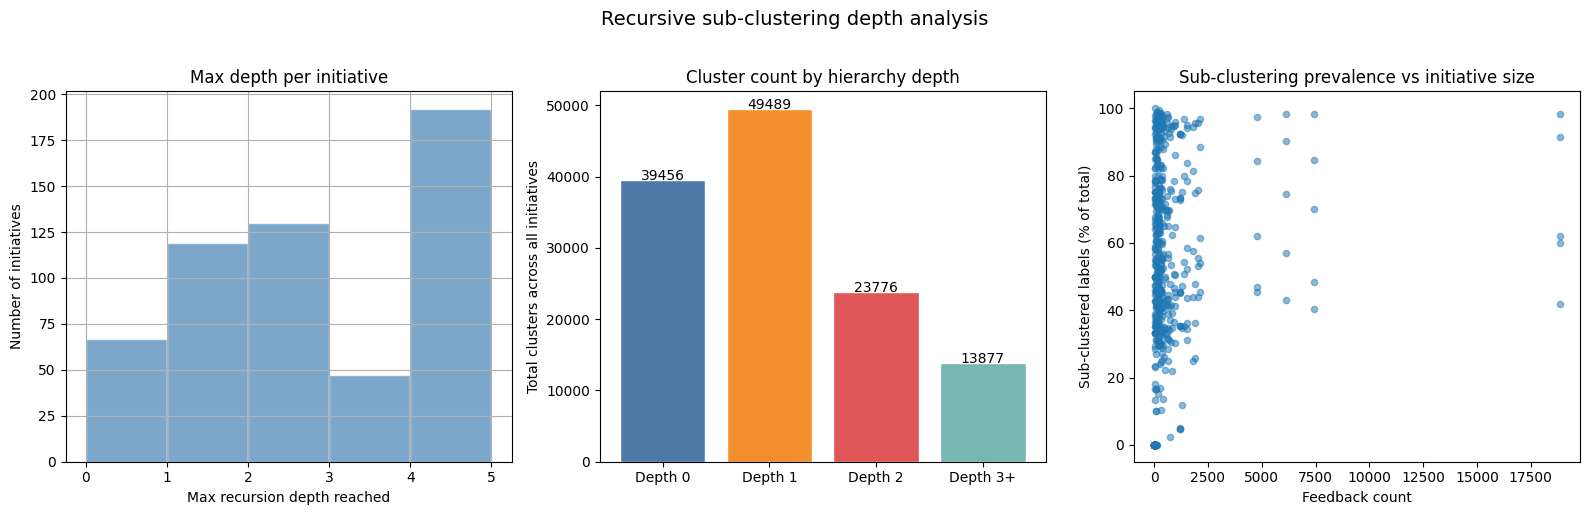

In [27]:
# ── Recursive: depth distribution histograms ───────────────────────────
if recursive_df is not None:
    rdf = recursive_df

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    ax = axes[0]
    rdf["max_depth"].hist(ax=ax, bins=range(0, rdf["max_depth"].max() + 2),
                          color="steelblue", alpha=0.7, edgecolor="white")
    ax.set_xlabel("Max recursion depth reached")
    ax.set_ylabel("Number of initiatives")
    ax.set_title("Max depth per initiative")

    ax = axes[1]
    depth_cols = ["clusters_at_depth_0", "clusters_at_depth_1",
                  "clusters_at_depth_2", "clusters_at_depth_3"]
    depth_labels = ["Depth 0", "Depth 1", "Depth 2", "Depth 3+"]
    totals = [rdf[c].sum() for c in depth_cols]
    ax.bar(depth_labels, totals, color=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"],
           edgecolor="white")
    for i, v in enumerate(totals):
        ax.text(i, v + 10, str(v), ha="center", fontsize=10)
    ax.set_ylabel("Total clusters across all initiatives")
    ax.set_title("Cluster count by hierarchy depth")

    ax = axes[2]
    rdf["sub_cluster_pct"] = rdf["n_sub_clustered"] / rdf["n_clusters"] * 100
    ax.scatter(rdf["n_feedback"], rdf["sub_cluster_pct"], alpha=0.5, s=20)
    ax.set_xlabel("Feedback count")
    ax.set_ylabel("Sub-clustered labels (% of total)")
    ax.set_title("Sub-clustering prevalence vs initiative size")

    plt.suptitle(f"Recursive sub-clustering depth analysis", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()